In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import copy
from scipy import ndimage

%matplotlib inline

In [2]:
WHITE = 240

In [3]:
path = "Folhas/Teste01.png"
im0 = cv2.imread(path)

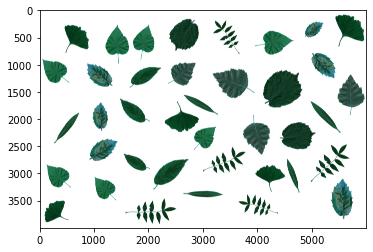

(4000, 6000, 3)


In [4]:
plt.imshow(im0)
plt.show()
print(np.shape(im0))

In [5]:
#dicionário que define as 8 posíveis posições de um vizinho, iniciando pelo vizinho à esquerda
neighbors = {
    "n_1": [ 0,-1],
    "n_2": [-1,-1],
    "n_3": [-1, 0],
    "n_4": [-1, 1],
    "n_5": [ 0, 1],
    "n_6": [ 1, 1],
    "n_7": [ 1, 0],
    "n_8": [ 1,-1]
}

In [6]:
# função para buscar no dicionário em qual posição "neig" está em relação a "center"
def find_n(center, neig):
    cont_n = 1
    while not np.array_equal(neig, center + neighbors["n_"+str(cont_n)]):
        if cont_n==8:
            cont_n=1
        else:
            cont_n+=1
    return cont_n

In [7]:
# passos 3 a 5 do Agoritmo Seguidor de Fronteira
def frontier_explorator(b, c, matrix, b_0, frontier):
    # flag booleana que determina se o laço deve continuar. Torna-se verdadeira quando b=b_0
    back_to_beginning = False

    while not back_to_beginning:
        # verifica qual o n do c atual
        cont_n = find_n(b, c)
        
        # incrementa n para começar a olhar para o próximo vizinho
        cont_n+=1
        # nk = próximo vizinho
        nk = b + neighbors["n_"+str(cont_n)]

        # se o próximo vizinho já é o desejado, o próximo laço não é ocorre. A variável walk determina se o laço foi acessado ou não, a fim de realizar as correções posteriores da variável
        walk = False    
        
        # laço busca o próximo pixel vizinho que não é branco
        while np.average(matrix[nk[0], nk[1]])>WHITE:
            walk = True
            nk = b + neighbors["n_"+str(cont_n)]
            if cont_n==8:
                cont_n=1
            else:
                cont_n+=1
        
        # se o laço anterior foi acessado, é preciso decrementar cont_n
        if walk:
            if cont_n!=1:
                cont_n-=1
            else:
                cont_n=8

        # cria a variável "k_minus_1", que guarda o índice do vizinho anterior
        if cont_n != 1:
            k_minus_1 = cont_n-1
        else:
            k_minus_1 = 8

        # c corresponde ao vizinho anterior, b corresponde ao vizinho de valor 1
        c = b + neighbors["n_"+str(k_minus_1)]
        b = nk

        # joga o valor de b pra lista de pixels da fronteira
        frontier += [b]

        # verifica se b já voltou pro começo pra continuar a percorrer a fronteira
        if np.array_equal(b,b_0):
            back_to_beginning = True

    return frontier

In [8]:
# inicia o Algoritmo Seguidor de Fronteira com os Passos 1 e 2
def frontier_finder(b_0, matrix):
    height = np.shape(matrix)[0]
    width  = np.shape(matrix)[1]

    # percorre os pixels brancos da imagem até encontrar o primeiro pixel não-branco
    while np.average(matrix[b_0[0], b_0[1]])>WHITE:
        if b_0[1]!= width-1:
            b_0+=[0,1]
        else:
            if b_0[0]==height-1:
                return
            b_0+=[1,-width+1]

    # define c como o vizinho da esquerda do primeiro pixel não-branco
    c = b_0 + neighbors["n_1"]

    # procura o primeiro vizinho não branco para ser o próximo c
    cont_n = 1
    while np.average(matrix[c[0], c[1]])>WHITE:
        c = b_0 + neighbors["n_"+str(cont_n)]
        if cont_n==8:
            cont_n=1
        else:
            cont_n+=1

    # passa o valor do atual pixel não-branco (c) para b, e passa o valor de b_0 para c
    b, c = c, b_0
    
    # adiciona b_0 e b para a lista de pixels percorridos
    frontier = [b_0, b] 
    frontier = frontier + frontier_explorator(b, c, matrix, b_0, frontier)

    return frontier

In [9]:
teste = np.array([[0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,128,128,128,128,0,0,0,0,0],
                  [0,0,128,128,128,128,0,0,255,255,0,0],
                  [0,0,128,128,128,0,0,255,255,255,255,0],
                  [0,0,128,128,0,0,255,255,255,255,255,0],
                  [0,0,128,0,0,255,255,255,255,255,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0]])

height = np.shape(im0)[0]
width = np.shape(im0)[1]

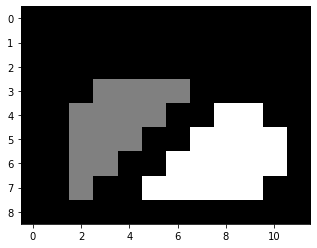

(9, 12)


In [10]:
plt.imshow(teste,cmap='gray', vmin=0, vmax=255)
plt.show()
print(np.shape(teste))

In [11]:
# chama o algoritmo seguidor de fronteira e armazena sua fronteira em "frontier"
frontier = frontier_finder(np.array([0,1]), im0)
frontier_matrix = np.array(frontier)

In [12]:
np.shape(frontier)

(4122, 2)

### Jogar frontier pra uma nova imagem e limpar ele da imagem original

In [13]:
min_y = np.min(frontier_matrix[:,0])
max_y = np.max(frontier_matrix[:,0])
min_x = np.min(frontier_matrix[:,1])
max_x = np.max(frontier_matrix[:,1])

frontier_height = max_y - min_y
frontier_width  = max_x - min_x

# padding de 1 ao redor da fronteira
new_height = frontier_height+3 
new_width = frontier_width+3
border_img = np.zeros((new_height, new_width))

In [14]:
# reposiciona as coordernadas de frontier_matrix para o canto superior esquerdo
frontier_matrix = frontier_matrix - [min_y-1, min_x-1]

# transfere a fronteira para "new_img"
for f in frontier_matrix:
    border_img[f[0], f[1]] = 1

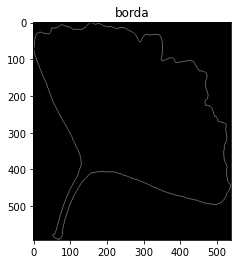

In [15]:
plt.imshow(border_img,cmap='gray')
plt.title("borda")
plt.show()

In [16]:
mask = copy.deepcopy(border_img)
mask = ndimage.binary_fill_holes(mask).astype(int)

In [17]:
# adiciona 3ª dimensão em mask3D para que o broadcast seja possível
mask3D = np.zeros((new_height, new_width, 1))
# pega os valores de mask
mask3D[:,:,0] = mask
# converte mask3D em uma matriz booleana
mask3D = np.array(mask3D, dtype=bool)

In [18]:
print(np.max(mask))

1


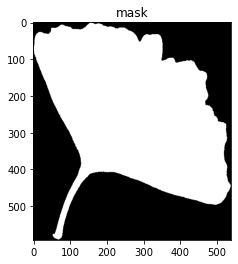

In [19]:
plt.imshow(mask, cmap='gray')
plt.title("mask")
plt.show()

In [20]:
new_img = np.zeros((new_height, new_width,3))
new_img = np.multiply(im0[min_y-1:max_y+2, min_x-1:max_x+2], mask3D)
im0[min_y-1:max_y+2, min_x-1:max_x+2,:] = np.multiply(im0[min_y-1:max_y+2, min_x-1:max_x+2], np.logical_not(mask3D))

In [23]:
# troca fundos pretos da aplicação da máscara por fundos branco
for i in range(new_height):
    for j in range(new_width):
        if mask3D[i,j,0]==0:
            new_img[i,j]=[255,255,255]
        else:
            im0[i+min_y-1, j+min_x-1] = [255,255,255]

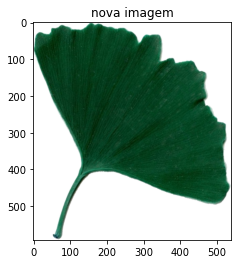

In [24]:
plt.imshow(new_img)
plt.title("nova imagem")
plt.show()

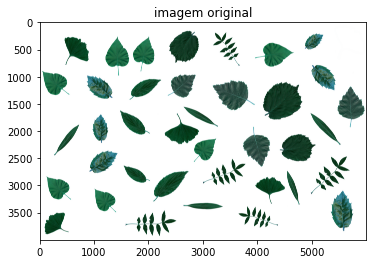

In [25]:
plt.imshow(im0)
plt.title("imagem original")
plt.show()